dataset:

---

https://github.com/liaopeiyuan/artbench

In [ ]:
# mlflow dependencies
pip install mlflow pyngrok --quiet

In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
!ls /content/utils

artworks_helpers.py  fastai_utils.py  mlflow_utils.py


change imports

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

In [ ]:
from artworks_helpers import genres_sorted_era
from fastai_utils import format_lrs, plot_confusion_matrix_vocab
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME)

In [ ]:
active_experiment_id

'1'

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
    'model_name': 'resnet18_pretrained',
}

In [ ]:
paintings_no_transform = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)
dls = paintings_no_transform.dataloaders(path/"train", bs=BATCH_SIZE)

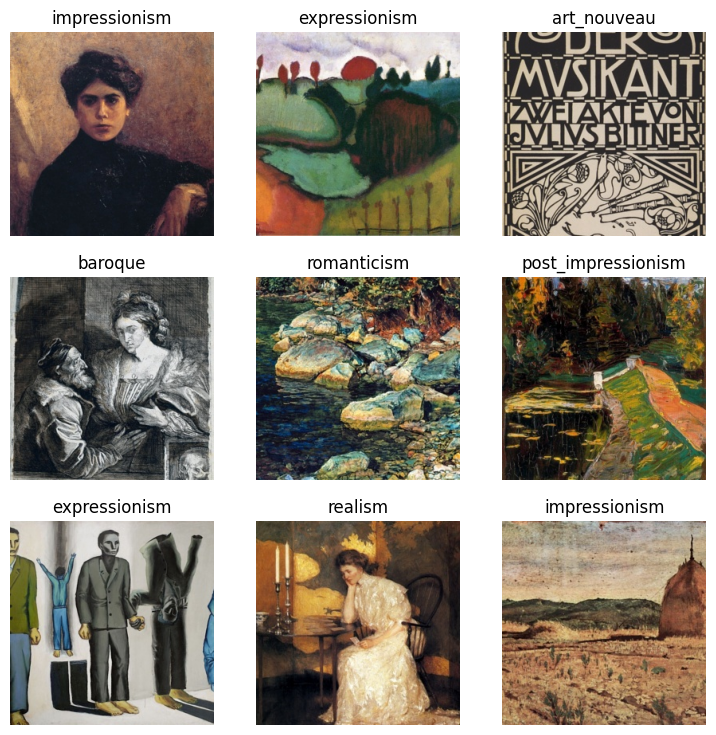

In [ ]:
dls.show_batch()

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
format_lrs(learn_rate)

metric: valley,  learning_rate:  0.001202
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: slide,  learning_rate:  0.003020
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: steep,  learning_rate:  0.003631
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: minimum,  learning_rate:  0.004786
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



"training procedure"

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_fine_tune') as run:
    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fine_tune(run_params['num_epochs'], base_lr=run_params['learning_rate'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_01.pkl')

artifact_uri saved as model
runs:/3107788db6b445bbbdc813193bf201eb/fastai_model/fastai_resnet18_01.pkl


In [ ]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

  34003 ?        Sl     0:05 /usr/bin/python3 /usr/local/bin/mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000


In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)

MLflow Tracking UI: https://f92e-34-16-248-186.ngrok-free.app


'https://f92e-34-16-248-186.ngrok-free.app'